## Genome-wide gene-level HDs

In [1]:
import pandas as pd
import os
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import statsmodels.formula.api as smf
import matplotlib.patches as mpatches
import random
import itertools
import re
import sys
sys.path.append("../1_data_processing")
import warnings
warnings.simplefilter("ignore")

import graphing_params as gp
import processing_utils as util
%load_ext autoreload
%autoreload 1
%aimport graphing_params
%aimport processing_utils

get_data_path = lambda folders, fname: os.path.normpath(os.environ['THIRD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

file_genes = get_local_data_path(['processed'], 'HGNC_gene_annot_ens93_hg19.csv')
folder_hd_maps = lambda fname: get_local_data_path(['processed','HD_maps'], fname)
file_chrom_info = get_local_data_path(['processed'], 'hg19_chrom_info.csv')
file_fragsites = get_local_data_path(['processed'], 'hg19_fragile_sites.csv')

### Load data

In [2]:
genes = pd.read_csv(file_genes)
passenger_genes = genes[~genes.TSG & ~genes.OG & ~genes.within_driver & ~genes.outside_bounds]
print('N genes:', genes.shape[0], passenger_genes.shape[0])

N genes: 17572 16898


In [3]:
tcga_hd_map = util.deserialize_map(folder_hd_maps("tcga_hd_map_full.csv"))

In [4]:
icgc_hd_map = util.deserialize_map(folder_hd_maps("icgc_hd_map.csv"))

In [4]:
tcga_hds = util.count_dels_per_gene(tcga_hd_map, genes)

In [6]:
icgc_hds = util.count_dels_per_gene(icgc_hd_map, genes)

### Drawing functions

In [5]:
def draw_gene_dels_for_chrom(dels, c, ax, chrom_info, yticks, color='#888', ylim=40):
    df = dels[dels.chr==c][['cds_from','n_del']].reset_index(drop=True)
    df.loc[df.shape[0]] = [chrom_info.loc[str(c)].centStart, 0]
    sns.lineplot(x=df.cds_from/1000000, y=df.n_del.clip(upper=40), color=color, ax=ax, zorder=0, drawstyle='steps-post')
    if ylim==40: ax.set_ylim([-10,40]); ax.set_yticks([0,20,40]); ax.set_yticklabels(['0','20','40+'])
    else: ax.set_ylim([-10,20]); ax.set_yticks([0,10,20]); ax.set_yticklabels(['0','10','20'])
    #ax.xaxis.set_tick_params(labelbottom=True)
    gp.set_axis_props(ax, show_yticks=yticks, ylabel='', xlabel='Genomic coordinates (Mb)', title='Chr'+str(c))

def draw_genes_for_chrom(genes, c, ax, color='orange', offset=10000, ymax=0.15, alpha=1):
    for row in genes[genes.chr==c].iterrows():
        x1=row[1].cds_from-offset; x2=row[1].cds_to+offset
        ax.axvspan(x1/1000000, x2/1000000, color=gp.get_color(color), lw=0, ymax=ymax, alpha=alpha)
        
def draw_centromere_for_chrom(chrom_info, c, ax, color='#aaa', ymax=1):
    ax.axvline((chrom_info.loc[str(c)].centStart/1000000)+1.5, linestyle='--', color=color, ymax=ymax)
    
def draw_fragsites_for_chrom(fragsites, c, ax, offset=10000, ymax=0.15, alpha=0.7):
    for row in fragsites[fragsites.chr==c].iterrows():
        x1=row[1].startpos-offset; x2=row[1].endpos+offset
        ax.axvspan(x1/1000000, x2/1000000, color=gp.get_color('sky-blue'), lw=0, ymax=ymax, alpha=alpha)

### Gene HDs along the genome

In [6]:
chrom_info = pd.read_csv(file_chrom_info, index_col=0)

In [7]:
fragsites = pd.read_csv(file_fragsites)

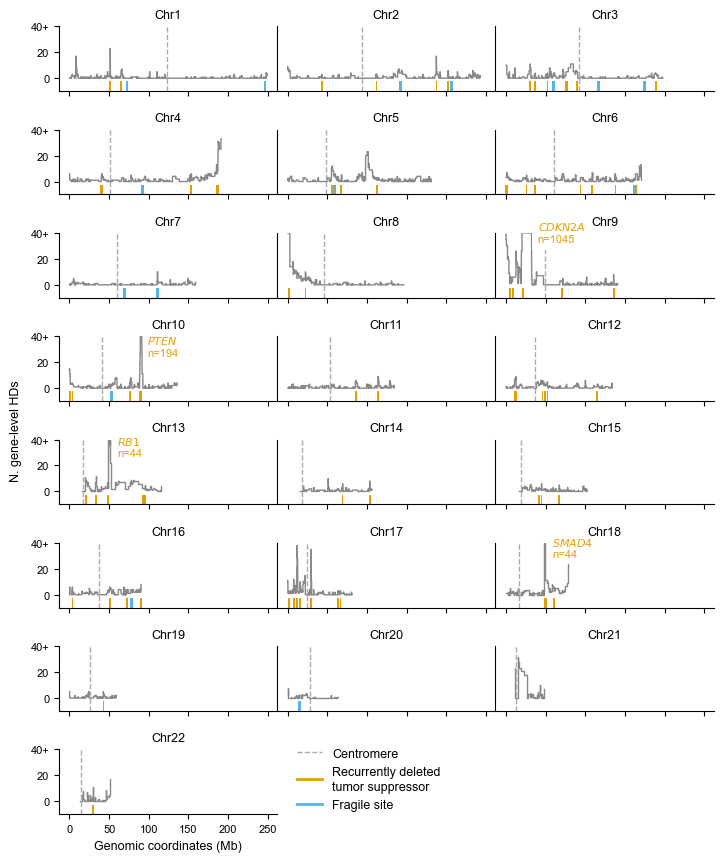

In [8]:
f, ax = plt.subplots(8, 3, figsize=(7.1, 8.7), sharex=True, sharey=True); ax=ax.flatten() # order='F'
for i,c in enumerate(range(1,23)):
    draw_gene_dels_for_chrom(tcga_hds, c, ax[i], chrom_info, yticks=(i%3==0))
    draw_genes_for_chrom(tcga_hds[(tcga_hds.n_del>=3) & tcga_hds.TSG], c, ax[i], color='orange', offset=1100000)
    draw_fragsites_for_chrom(fragsites, c, ax[i], offset=1100000, alpha=1) 
    draw_centromere_for_chrom(chrom_info, c, ax[i], color='#aaa')
f.text(-0.01, 0.5, 'N. gene-level HDs', rotation=90, verticalalignment="center")
ax[22].axis("off"); ax[23].axis("off")
plt.tight_layout(h_pad=1.3, w_pad=0)

ax[8].text(40, 33, '$\it{CDKN2A}$\nn=1045', color=gp.get_color('orange'), fontsize=8,
           bbox=dict(facecolor='w', edgecolor='none'))
ax[9].text(98, 25, '$\it{PTEN}$\nn=194', color=gp.get_color('orange'), fontsize=8)
ax[12].text(60, 27, '$\it{RB1}$\nn=44', color=gp.get_color('orange'), fontsize=8)
ax[17].text(58, 29, '$\it{SMAD4}$\nn=44', color=gp.get_color('orange'), fontsize=8)

gp.draw_legend(ax[22], labels=['Centromere','Recurrently deleted\ntumor suppressor','Fragile site'], 
               styles=['--','-','-'], colors=['#aaa', gp.get_color('orange'), gp.get_color('sky-blue')], 
               lw=[1,2,2], bbox_to_anchor=(0.8, 1.2))
plt.savefig('../figures/HD_distrib.png', bbox_inches='tight', dpi=500)

### Chromosome 3 segments

In [9]:
def draw_hd_segments_for_chrom(tcga_hds_an, c, ax):
    data=tcga_hds_an[(tcga_hds_an.chr==c)&(tcga_hds_an.genes.apply(lambda x: len(x)>0))].sort_values(['startpos','endpos'])
    print(data.shape[0])
    idx = 0; prev_max=-1; offset=200000
    for d in data.iterrows():
        if prev_max < d[1].startpos-(offset*4): idx=0
        else: idx += 1
        prev_max = d[1].endpos+offset
        ax.hlines(y=-idx, xmin=(d[1].startpos-offset)/1000000, xmax=(d[1].endpos+offset)/1000000, lw=1.5,
                  color=(gp.get_color('orange') if d[1].tsg else 
                         (gp.get_color('sky-blue') if d[1].fragsite or d[1].centromere or d[1].telomere else '#aaa')))

In [11]:
tcga_hd_map_annot = util.deserialize_map(folder_hd_maps("tcga_hd_map_annot_full.csv"))

149


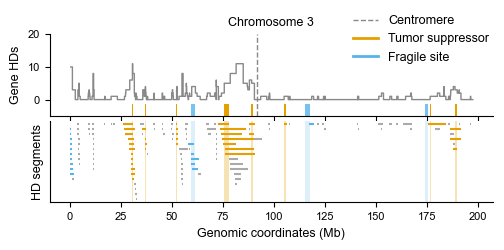

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(5.1, 2.5), sharex=True)
chrom = 3
draw_gene_dels_for_chrom(tcga_hds, chrom, ax[0], chrom_info, yticks=True, ylim=20)
draw_centromere_for_chrom(chrom_info, chrom, ax[0], color='#888')

draw_fragsites_for_chrom(fragsites, chrom, ax[0], alpha=0.8)
draw_fragsites_for_chrom(fragsites, chrom, ax[1], alpha=0.2, ymax=1)

hd_tsgs = tcga_hds[tcga_hds.TSG & (tcga_hds.n_del>=1) & (tcga_hds.symbol!='FHIT')]
draw_genes_for_chrom(hd_tsgs, chrom, ax[0], color='orange', offset=200000)
draw_genes_for_chrom(hd_tsgs, chrom, ax[1], color='orange', offset=200000, alpha=0.3, ymax=1)
ax[0].set_ylim([-5,20]); #ax[0].grid(axis='y')

df = tcga_hd_map_annot.assign(tsg = tcga_hd_map_annot.apply(lambda x: False if x.fragsite else x.tsg, axis=1))
draw_hd_segments_for_chrom(df, chrom, ax[1])

gp.set_axis_props(ax[0], xlabel='', ylabel='Gene HDs', title='Chromosome '+str(chrom))
gp.set_axis_props(ax[1], show_yticklabels=False, ylabel='HD segments', xlabel='Genomic coordinates (Mb)')
plt.tight_layout(h_pad=0)
gp.draw_legend(ax[0], labels=['Centromere','Tumor suppressor','Fragile site'], styles=['--','-','-'],
              colors=['#888', gp.get_color('orange'), gp.get_color('sky-blue')], lw=[1,2,2], 
               bbox_to_anchor=(0.66, 0.5))
plt.savefig('../figures/gene_del_chr3.png', bbox_inches='tight', dpi=300)

151


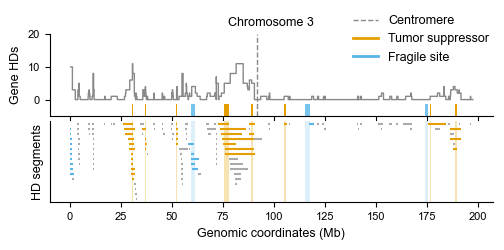

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(5.1, 2.5), sharex=True)
chrom = 3
draw_gene_dels_for_chrom(tcga_hds, chrom, ax[0], chrom_info, yticks=True, ylim=20)
draw_centromere_for_chrom(chrom_info, chrom, ax[0], color='#888')

draw_fragsites_for_chrom(fragsites, chrom, ax[0], alpha=0.8)
draw_fragsites_for_chrom(fragsites, chrom, ax[1], alpha=0.2, ymax=1)

hd_tsgs = tcga_hds[tcga_hds.TSG & (tcga_hds.n_del>=1) & (tcga_hds.symbol!='FHIT')]
draw_genes_for_chrom(hd_tsgs, chrom, ax[0], color='orange', offset=200000)
draw_genes_for_chrom(hd_tsgs, chrom, ax[1], color='orange', offset=200000, alpha=0.3, ymax=1)
ax[0].set_ylim([-5,20]); #ax[0].grid(axis='y')
                                                       
df = tcga_hd_map_annot.assign(tsg = tcga_hd_map_annot.apply(lambda x: False if x.fragsite else x.tsg, axis=1))
draw_hd_segments_for_chrom(df, chrom, ax[1])

gp.set_axis_props(ax[0], xlabel='', ylabel='Gene HDs', title='Chromosome '+str(chrom))
gp.set_axis_props(ax[1], show_yticklabels=False, ylabel='HD segments', xlabel='Genomic coordinates (Mb)')
plt.tight_layout(h_pad=0)
gp.draw_legend(ax[0], labels=['Centromere','Tumor suppressor','Fragile site'], styles=['--','-','-'],
              colors=['#888', gp.get_color('orange'), gp.get_color('sky-blue')], lw=[1,2,2], 
               bbox_to_anchor=(0.66, 0.5))
plt.savefig('../figures/gene_del_chr3.png', bbox_inches='tight', dpi=300)

#### Recurrently deleted TSGs on chr 3

In [27]:
df = tcga_hds.sort_values(['chr','cds_from']).reset_index(drop=True)
display(df[(df.chr==3) & (df.TSG) & (df.n_del>=3)])

,entrez_id,n_del,symbol,ensembl_id,chr,cds_from,cds_to,ccds_id,cds_len,cds_mid,...,depmap_ess,depmap_ess_cat,ess_gt,ess_3D,TSG_CGC,TSG_Bailey,TSG,OG,within_driver,outside_bounds
3186,7048,11.0,TGFBR2,ENSG00000163513,3,30648375,30733090,CCDS33727,84715,30690732.5,...,False,sometimes,False,False,True,True,True,False,False,False
3211,4292,3.0,MLH1,ENSG00000076242,3,37035038,37092143,CCDS2663,57105,37063590.5,...,False,sometimes,False,False,True,True,True,True,False,False
3432,8314,3.0,BAP1,ENSG00000163930,3,52436303,52443893,CCDS2853,7590,52440098.0,...,False,sometimes,False,False,True,True,True,False,False,False
3487,2272,4.0,FHIT,ENSG00000189283,3,59737951,60522694,CCDS2894,784743,60130322.5,...,False,never,NaN,False,True,False,True,False,False,False
3524,6092,5.0,ROBO2,ENSG00000185008,3,75986644,77695205,CCDS54609,1708561,76840924.5,...,False,sometimes,False,False,True,False,True,False,False,False
3535,2042,5.0,EPHA3,ENSG00000044524,3,89156898,89528651,CCDS2922,371753,89342774.5,...,False,sometimes,False,False,True,True,True,True,False,False
4013,8626,3.0,TP63,ENSG00000073282,3,189349304,189612290,CCDS3293,262986,189480797.0,...,False,sometimes,False,False,True,False,True,True,False,False


In [28]:
# Genes in the peak around the TSG TGFBR2
df.iloc[3180:3189]

,entrez_id,n_del,symbol,ensembl_id,chr,cds_from,cds_to,ccds_id,cds_len,cds_mid,...,depmap_ess,depmap_ess_cat,ess_gt,ess_3D,TSG_CGC,TSG_Bailey,TSG,OG,within_driver,outside_bounds
3180,9497,3.0,SLC4A7,ENSG00000033867,3,27418254,27525616,CCDS58820,107362,27471935.0,...,False,sometimes,False,True,False,False,False,False,False,False
3181,8320,3.0,EOMES,ENSG00000163508,3,27758560,27763784,CCDS63585,5224,27761172.0,...,False,sometimes,False,False,False,False,False,False,False,False
3182,152100,3.0,CMC1,ENSG00000187118,3,28283284,28361119,CCDS33722,77835,28322201.5,...,False,sometimes,False,False,False,False,False,False,False,False
3183,64343,3.0,AZI2,ENSG00000163512,3,28365532,28382107,CCDS2647,16575,28373819.5,...,False,never,False,False,False,False,False,False,False,False
3184,152098,3.0,ZCWPW2,ENSG00000206559,3,28454559,28566178,CCDS33723,111619,28510368.5,...,False,sometimes,False,False,False,False,False,False,False,False
3185,27303,6.0,RBMS3,ENSG00000144642,3,29323172,30045352,CCDS54558,722180,29684262.0,...,False,never,False,False,False,False,False,False,False,False
3186,7048,11.0,TGFBR2,ENSG00000163513,3,30648375,30733090,CCDS33727,84715,30690732.5,...,False,sometimes,False,False,True,True,True,False,False,False
3187,339896,8.0,GADL1,ENSG00000144644,3,30769733,30936105,CCDS2649,166372,30852919.0,...,False,never,False,False,False,False,False,False,False,False
3188,201595,2.0,STT3B,ENSG00000163527,3,31574490,31677555,CCDS2650,103065,31626022.5,...,False,sometimes,False,False,False,False,False,False,False,False
